In [1]:
import numpy as np
import GPy
import pandas as pd
from GPy.kern import LinearSlopeBasisFuncKernel, DomainKernel, ChangePointBasisFuncKernel
from matplotlib import pyplot as plt

In [2]:
# Simulate from an OUF model
# OUF model simulation
def OUF(Tmax,beta,sigma,u0,z0,mu,gamma,dt):
    T = np.arange(0,Tmax,dt)
    n = len(T)
    u = z = n*[0]
    u[0] = u0 # set the initial value if you want to start with a different value rather than 0
    z[0] = z0
    dW = np.random.randn(n)*np.sqrt(dt) 
    for i in range(1,n):
        u[i] = u[i-1] - 1/beta*u[i-1] * dt  + sigma *dW[i]
    for i in range(1,n):
        z[i] = z[i-1] - 1/gamma*(z[i-1]-mu) * dt  + u[i]*dt
    return [u,z]    
# works

In [3]:
Tmax= 20
dt = 0.01
beta = 1
gamma =2 
sigma =0.3 
u0 = 0 
z0 = 0
mu = 0
z = np.array(OUF(Tmax,beta,sigma,u0,z0,mu,gamma,dt)[1])
T = np.array(np.arange(0,Tmax,dt))

In [4]:
t_column = T.reshape(-1,1)
x_column =z.reshape(-1,1)

In [5]:
t_column = t_column[::20]
x_column = x_column[::20]

 /home/pgrad1/2086253P/.local/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


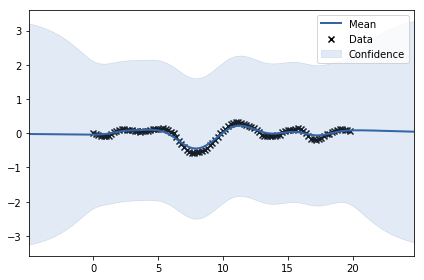

In [6]:
k1=GPy.kern.OrsteinUF(1,timescale_H=5.01,timescale_F=1.,sigma_a=1)
# Make a GP regression model
m1 = GPy.models.GPRegression(t_column,x_column,k1)
_=m1.plot()

In [7]:
print(m1) 



Name : GP regression
Objective : 104.73146775372896
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  OUF.timescale_H          |   5.01  |      +ve      |        
  OUF.timescale_F          |    1.0  |      +ve      |        
  OUF.sigma_a              |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [8]:
m1.optimize()


In [9]:
print(m1)


Name : GP regression
Objective : -240.51527891862816
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  OUF.timescale_H          |     1.3087072000556352  |      +ve      |        
  OUF.timescale_F          |     1.3087187892766015  |      +ve      |        
  OUF.sigma_a              |    0.11053233549745954  |      +ve      |        
  Gaussian_noise.variance  |  6.674643368556479e-06  |      +ve      |        


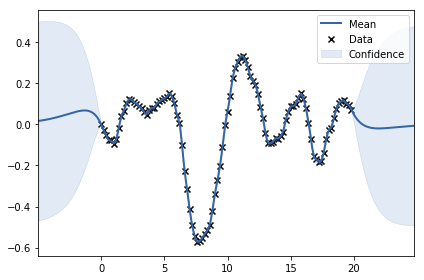

In [10]:
fig = m1.plot()

In [11]:
#Observation: even though I increase a lot the number of samples, timescale_H still doesn't go close to 1, 1.86
# this doesn't mean necesarilly that the formula is wrong, it just means the numerical approximations of the derivatives are not good enough

In [12]:
# define the kernel again 
k1=GPy.kern.OrsteinUF(1,timescale_H=5.,timescale_F=1.,sigma_a=1)
# Make a GP regression model
m1 = GPy.models.GPRegression(t_column,x_column,k1)

In [13]:
print(m1)
# make sure to start from unoptimized values


Name : GP regression
Objective : 104.72710631841223
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  OUF.timescale_H          |    5.0  |      +ve      |        
  OUF.timescale_F          |    1.0  |      +ve      |        
  OUF.sigma_a              |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [14]:
hmc1 = GPy.inference.mcmc.HMC(m1,stepsize=5e-2)
s1 = hmc1.sample(num_samples=100)

Text(0, 0.5, 'Parameter value')

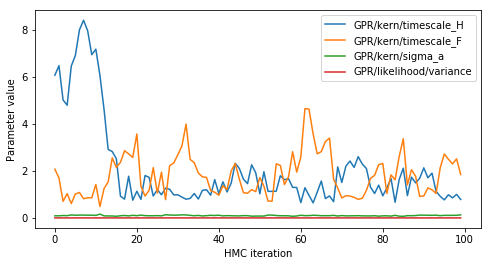

In [15]:
A1=s1
timescale_H_final_vector=[p[0] for p in A1]# variance goes first in GPy
timescale_F_final_vector=[p[1] for p in A1]
sigma_a_final_vector = [p[2] for p in A1]
likelihood_variance_final_vector = [p[3] for p in A1]
d = {'col1': timescale_H_final_vector, 'col2':timescale_F_final_vector, 'col3':sigma_a_final_vector, 'col4':likelihood_variance_final_vector}
df = pd.DataFrame(data=d)#, dtype=np.int8)
df.columns=['GPR/kern/timescale_H','GPR/kern/timescale_F','GPR/kern/sigma_a','GPR/likelihood/variance']# changing the names
samples1=df # rename it
plt.figure(figsize=(8,4))
for i, col in samples1.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('HMC iteration')
plt.ylabel('Parameter value')

In [16]:
labels = ['timescale_H', 'timescale_F','sigma_a','likelihood_variance']

Text(0, 0.5, 'timescale_H')

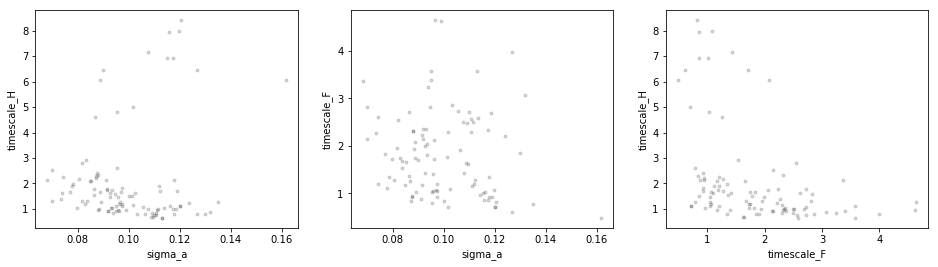

In [17]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
_=ax.plot(s1[:,2],s1[:,0],'k.', alpha = 0.15)
ax.set_xlabel(labels[2]); ax.set_ylabel(labels[0])
ax = fig.add_subplot(132)
_=ax.plot(s1[:,2],s1[:,1],'k.', alpha = 0.15)
ax.set_xlabel(labels[2]); ax.set_ylabel(labels[1])
ax = fig.add_subplot(133)
_=ax.plot(s1[:,1],s1[:,0],'k.', alpha = 0.15)
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[0])

Text(0, 0.5, 'likelihood_variance')

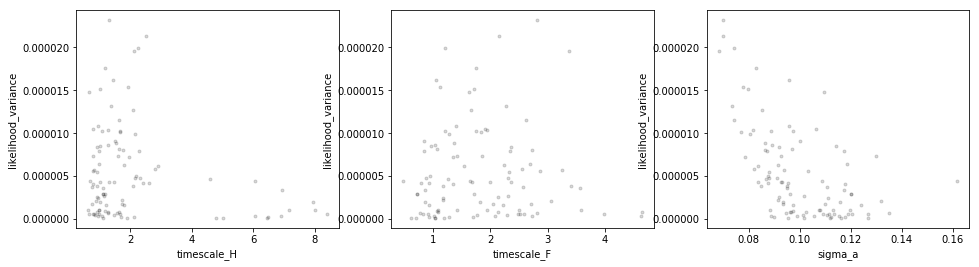

In [18]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
_=ax.plot(s1[:,0],s1[:,3],'k.', alpha = 0.15)
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[3])
ax = fig.add_subplot(132)
_=ax.plot(s1[:,1],s1[:,3],'k.', alpha = 0.15)
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[3])
ax = fig.add_subplot(133)
_=ax.plot(s1[:,2],s1[:,3],'k.', alpha = 0.15)
ax.set_xlabel(labels[2]); ax.set_ylabel(labels[3])